# [40%] Task 01: Emergent Subnetworks and Pruning Dependencies

## Background and Motivation

In Task 01, we explored basic pruning techniques that remove individual parameters or simple structures. However, real neural networks contain complex **architectural dependencies** between layers, modules, and components that must be carefully preserved during pruning. Ignoring these dependencies can lead to broken models, dimensional mismatches, or complete training failures.

## Key Concepts

**Pruning Dependencies**: The interconnected relationships between network components that must be maintained during pruning. These include:
- **Dimensional consistency**: Ensuring input/output dimensions match between connected layers
- **Residual connections**: Maintaining skip connections in architectures like ResNet
- **Batch normalization alignment**: Preserving feature map dimensions for normalization layers
- **Multi-branch structures**: Coordinating pruning across parallel pathways

...etc.

## Section Objectives

This section is worth **40%** of the total lab grade and focuses on understanding the critical importance of dependency-aware pruning:

1. **Identify architectural dependencies** in ResNet structures and analyze how they constrain pruning decisions
2. **Implement dependency-aware pruning** that maintains model functionality while achieving compression
3. **Demonstrate dependency violations** by intentionally breaking pruning rules and observing the consequences
4. **Compare pruning strategies** that respect vs. ignore architectural constraints
5. **Analyze emergent subnetworks** to understand how different pruning approaches affect final model structure and performance

**Goal**: Understand how different dependencies in neural network architectures must be maintained during pruning, and demonstrate how careless pruning leads to non-functional models, while dependency-aware approaches preserve both structure and performance.

---

### [20%] 2a: Understanding Pruning Dependencies and Dependency Graphs

Neural network architectures contain complex interdependencies between layers that must be carefully managed during pruning. When we remove channels, filters, or entire layers, we must ensure that the remaining network components maintain proper dimensional consistency and connectivity. Failure to respect these dependencies results in broken models with mismatched tensor dimensions or disconnected computational graphs.

---

#### What Are Pruning Dependencies?

**Pruning dependencies** are structural relationships between network components that constrain how pruning can be safely applied:

- **Channel Dependencies**: When one layer’s output channels feed into another layer’s input channels.
- **Residual Dependencies**: Skip connections that require matching dimensions between branched paths.
- **Normalization Dependencies**: Batch normalization layers that must align with their corresponding feature maps.
- **Multi-head Dependencies**: Attention mechanisms where each head must maintain consistent dimensions.

---

#### Dependency Graphs

A **dependency graph** is a directed graph that represents pruning constraints across a model:

- **Nodes** represent layers, modules, or parameter groups.
- **Edges** represent structural or dataflow dependencies.
- **Constraints** define which components must be pruned together to preserve correctness.

---

#### TorchPruning Library

We will use the [`torch-pruning`](https://github.com/VainF/Torch-Pruning) library to automatically analyze and respect these dependencies. It provides:

1. **Automatic dependency detection** for common architectures such as ResNet and DenseNet.
2. **Graph-based visualization** for understanding inter-layer constraints.
3. **Group-wise pruning utilities** to ensure shape and execution integrity.
4. **Multiple pruning strategies** that respect network structure.

---

#### Experimental Tasks

In this section, you will:

1. Analyze dependency graphs for ResNet using `torch-pruning`.
2. Implement dependency-aware pruning with the library’s group pruning API.
3. Compare dependency-aware pruning to naive pruning by intentionally breaking dependencies.
4. Visualize pruned subnetworks to observe how dependencies affect pruning outcomes.
5. Measure the effects of dependency violations on model functionality and training stability.

---

#### Expected Outcomes

By completing this section, you will understand:

- How architectural dependencies constrain pruning decisions.
- Why preserving dependency relationships is essential for model correctness.
- How pruning libraries like `torch-pruning` handle these relationships automatically.
- The trade-offs between aggressive pruning and maintaining structural integrity.


In [1]:
# download torch pruning:
# !pip install torch-pruning --upgrade

## Analyzing Dependencies in ResNet-18 Using `torch-pruning` (10%)

When pruning neural networks, it's critical to understand how layers are interconnected. In modern architectures like **ResNet-18**, layers are not independent—especially due to **residual connections** and **shape-altering operations** (e.g., downsampling, channel projection).

If you prune one layer, others may need to be pruned accordingly to maintain consistency. This is where `torch-pruning`'s `DependencyGraph` becomes essential.

---

### Goal of This Function

The function `analyze_all_dependencies(model)` inspects a pretrained **ResNet-18** to uncover output channel dependencies in convolutional layers. It uses the `DependencyGraph` class from the `torch-pruning` library to:

- Build a graph of inter-layer dependencies using example inputs.
- Iterate over all `nn.Conv2d` layers.
- For each layer, compute how pruning one output channel affects other layers.
- Print out the first few dependencies for inspection.

This helps you **visualize the propagation of pruning decisions** through the network, enabling more informed and structurally consistent pruning.

---

### Key Concepts

- **DependencyGraph**: Captures how pruning one layer influences others.
- **Pruning Group**: A collection of operations (e.g., convolutions, batch norms) that must be pruned together to maintain shape and computation correctness.
- **Output Channel Pruning**: A common type of structural pruning where output channels in convolution layers are removed.

---

### Your Task

You’ll implement and run `analyze_all_dependencies` on a pretrained **ResNet-18**.


In [15]:
import torch
import torch_pruning as tp
from torchvision.models import resnet18, resnet50
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# you will finish this
def analyze_all_dependencies(model):
    DG = tp.DependencyGraph().build_dependency(model, example_inputs=torch.randn(1,3,224,224))

    print("=== Complete Dependency Analysis ===")

    # Get all conv layers
    conv_layers = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            conv_layers.append((name, module))

    for name, layer in conv_layers[:5]:  # Show first 5 conv layers
        print(f"\n--- {name} ---")
        try:
            group = DG.get_pruning_group(layer, tp.prune_conv_out_channels, idxs=[0])
            print(f"Output channel dependencies: {len(group)} ops affected")
            for i, dep in enumerate(list(group)[:3]):
                print(f"  [{i}] {dep}")
        except Exception as e:
            print(f"  Error: {e}")

model = resnet18(pretrained=True).eval()
analyze_all_dependencies(model)

=== Complete Dependency Analysis ===

--- conv1 ---
Output channel dependencies: 16 ops affected
  [0] (prune_out_channels on conv1 (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)) => prune_out_channels on conv1 (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)), [0])
  [1] (prune_out_channels on conv1 (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)) => prune_out_channels on bn1 (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)), [0])
  [2] (prune_out_channels on bn1 (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)) => prune_out_channels on _ElementWiseOp_20(ReluBackward0), [0])

--- layer1.0.conv1 ---
Output channel dependencies: 4 ops affected
  [0] (prune_out_channels on layer1.0.conv1 (Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)) => prune_out_channels on layer1.0.conv1 (Conv2d(64, 64, kernel_size=(3,

/home/tanush/Programming/School/CS4803-EML/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tanush/Programming/School/CS4803-EML/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Efficient Pruning Strategy Evaluation (10%)

In this exercise, you will evaluate the impact of different channel pruning strategies on a pretrained **ResNet-50** using the `torch-pruning` library. The goal is to understand how various approaches to pruning affect model compression and runtime performance, while maintaining network integrity through dependency-aware pruning.

### Pruning Strategies

You will implement and evaluate the following three strategies:

1. **Local L2 Magnitude Pruning**  
   Prunes channels within each layer independently based on L2 norm magnitude.

2. **Global Magnitude Pruning with Isomorphic Ranking**  
   Applies a global ranking across all layers, enforcing a uniform pruning ratio while respecting inter-layer constraints.

3. **Layer-wise Custom Ratio Pruning**  
   Manually specifies pruning ratios for individual layers to tailor compression across the network.

In each case, the dependency graph will be used to propagate pruning decisions and ensure shape consistency across layers.

---

### Tasks

For each of the three strategies:

- Run pruning on the pretrained ResNet-50 model.
- Collect and report the following metrics:
  - **MACs reduction**
  - **Parameter reduction**
  - **Inference latency**

Then:

- Compare the results across strategies.
- Identify which method offers the best trade-off between compression and speed.

---

### Dependency Graph Analysis

Examine the dependency graph of ResNet-50 and answer the following:

- Why does pruning early layers such as `conv1` affect so many downstream operations?
- What implications does this have for safe structured pruning?

---

### Hardware Consideration

- Briefly explain how the `round_to` parameter (e.g., `round_to=8`) supports **hardware efficiency** and **tensor alignment** in convolution operations.

---

### Final Deliverables

Your submission should include:

1. A **performance comparison table** for all three strategies.
2. **Key takeaways** summarizing the pros and cons of each method.
3. Concise **answers to the conceptual questions** regarding dependency impact and hardware alignment.
4. Optional: Visualizations of the pruned network architecture or dependency graphs to support your analysis.


In [4]:
# No need to edit this.
def setup_model_and_data():
    """Setup the ResNet model and example inputs"""
    # Load pre-trained ResNet-50
    model = resnet50(pretrained=True)
    model.eval()

    # Create example inputs
    example_inputs = torch.randn(1, 3, 224, 224)

    # Get baseline metrics
    base_macs, base_params = tp.utils.count_ops_and_params(model, example_inputs)

    print(f"Original Model - MACs: {base_macs/1e9:.3f}G, Params: {base_params/1e6:.3f}M")

    return model, example_inputs, base_macs, base_params

In [5]:
# No need to edit this.
def measure_inference_time(model, example_inputs, num_runs=50):
    """Measure average inference time"""
    model.eval()
    with torch.no_grad():
        # Warmup
        for _ in range(5):
            _ = model(example_inputs)

        # Actual measurement
        start_time = time.time()
        for _ in range(num_runs):
            _ = model(example_inputs)
        end_time = time.time()

    avg_time = (end_time - start_time) / num_runs * 1000  # Convert to ms
    return avg_time

In [6]:
def prune_with_magnitude(example_inputs, base_macs, base_params):
    """Strategy 1: L2 Magnitude-based pruning"""
    print("\n" + "="*50)
    print("STRATEGY 1: L2 Magnitude-based Pruning")
    print("="*50)

    # Create fresh model for this strategy
    model_mag = resnet50(pretrained=True)
    model_mag.eval()

    # Define importance criterion - L2 norm of grouped weights
    importance = tp.importance.GroupMagnitudeImportance(p=2)

    # Ignore the final classifier to maintain output dimensions
    ignored_layers = [model_mag.fc]  # ResNet classifier

    # Initialize pruner
    # make it have pruning ratio of 0.5
    pruner = tp.pruner.MetaPruner(
        model_mag,
        example_inputs,
        importance=importance,
        pruning_ratio=0.5,
        ignored_layers=ignored_layers
    )

    # Apply pruning
    pruner.step()

    # Measure results
    macs, params = tp.utils.count_ops_and_params(model_mag, example_inputs)
    latency = measure_inference_time(model_mag, example_inputs)

    results = {
        'model': model_mag,
        'macs': macs,
        'params': params,
        'latency': latency,
        'macs_reduction': (base_macs - macs) / base_macs,
        'params_reduction': (base_params - params) / base_params
    }

    print(f"After Pruning - MACs: {macs/1e9:.3f}G ({results['macs_reduction']:.1%} reduction)")
    print(f"After Pruning - Params: {params/1e6:.3f}M ({results['params_reduction']:.1%} reduction)")
    print(f"Inference Time: {latency:.2f}ms")

    return results

In [7]:
def prune_with_global_magnitude(example_inputs, base_macs, base_params):
    """Strategy 2: Global Magnitude-based pruning with isomorphic ranking"""
    print("\n" + "="*50)
    print("STRATEGY 2: Global Magnitude Pruning with Isomorphic Ranking")
    print("="*50)

    # Create fresh model for this strategy
    model_global = resnet50(pretrained=True)
    model_global.eval()

    # Define importance criterion
    importance = tp.importance.GroupMagnitudeImportance(p=2)

    # Ignore the final classifier
    ignored_layers = [model_global.fc]

    # Initialize pruner with global pruning and isomorphic ranking
    pruner = tp.pruner.MetaPruner(
        model_global,
        example_inputs=example_inputs,
        importance=importance,
        global_pruning=True,
        isomorphic=True,
    )

    # Apply pruning
    pruner.step()

    # Measure results
    macs, params = tp.utils.count_ops_and_params(model_global, example_inputs)
    latency = measure_inference_time(model_global, example_inputs)

    results = {
        'model': model_global,
        'macs': macs,
        'params': params,
        'latency': latency,
        'macs_reduction': (base_macs - macs) / base_macs,
        'params_reduction': (base_params - params) / base_params
    }

    print(f"After Pruning - MACs: {macs/1e9:.3f}G ({results['macs_reduction']:.1%} reduction)")
    print(f"After Pruning - Params: {params/1e6:.3f}M ({results['params_reduction']:.1%} reduction)")
    print(f"Inference Time: {latency:.2f}ms")

    return results

In [8]:
def prune_with_layer_wise_ratios(example_inputs, base_macs, base_params):
    """Strategy 3: Customized layer-wise pruning ratios"""
    print("\n" + "="*50)
    print("STRATEGY 3: Layer-wise Custom Pruning Ratios")
    print("="*50)

    # Create fresh model for this strategy
    model_custom = resnet50(pretrained=True)
    model_custom.eval()

    # Define importance criterion
    importance = tp.importance.GroupMagnitudeImportance(p=2)

    # Ignore the final classifier
    ignored_layers = [model_custom.fc]

    # Define custom pruning ratios for different parts of the network
    # ResNet has 4 main layers - let's prune them differently
    # prune layer 1 w/ 0.3
    # prune layer 2 w/ 0.6
    # prune layer 3 w/ 0.5
    # prune layer 4 w/ 0.4
    pruning_ratio_dict = {
        model_custom.layer1: 0.3,
        model_custom.layer2: 0.6,
        model_custom.layer3: 0.5,
        model_custom.layer4: 0.4
    }

    # Initialize pruner with custom ratios
    pruner = tp.pruner.MetaPruner(
        model_custom,
        example_inputs,
        importance=importance,
        pruning_ratio_dict=pruning_ratio_dict,
        ignored_layers=ignored_layers
    )

    # Apply pruning
    pruner.step()

    # Measure results
    macs, params = tp.utils.count_ops_and_params(model_custom, example_inputs)
    latency = measure_inference_time(model_custom, example_inputs)

    results = {
        'model': model_custom,
        'macs': macs,
        'params': params,
        'latency': latency,
        'macs_reduction': (base_macs - macs) / base_macs,
        'params_reduction': (base_params - params) / base_params
    }

    print(f"After Pruning - MACs: {macs/1e9:.3f}G ({results['macs_reduction']:.1%} reduction)")
    print(f"After Pruning - Params: {params/1e6:.3f}M ({results['params_reduction']:.1%} reduction)")
    print(f"Inference Time: {latency:.2f}ms")

    return results

In [9]:
def analyze_dependency_graph(model, example_inputs):
    """Analyze the dependency graph structure"""
    print("\n" + "="*50)
    print("DEPENDENCY GRAPH ANALYSIS")
    print("="*50)

    # Build dependency graph
    DG = tp.DependencyGraph().build_dependency(model, example_inputs=example_inputs)

    # Get a sample pruning group to understand dependencies
    print("\nSample pruning group for conv1 (first convolutional layer):")
    try:
        # Get pruning group for the first conv layer
        group = DG.get_pruning_group(model.conv1, tp.prune_conv_out_channels, idxs=[2, 6, 9])
        print(f"Group size: {len(group)} coupled operations")
        print("\nFirst 10 dependencies:")
        for i, dep in enumerate(group[:10]):
            print(f"  [{i}] {dep}")

        print(f"\n... and {max(0, len(group)-10)} more dependencies")

        # Show how pruning conv1 affects the whole network
        print(f"\nPruning conv1 affects {len(group)} operations across the network!")

    except Exception as e:
        print(f"Error in dependency analysis: {e}")

In [10]:
base_model, example_inputs, base_macs, base_params = setup_model_and_data()

/home/tanush/Programming/School/CS4803-EML/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tanush/Programming/School/CS4803-EML/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
0.1%

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/tanush/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100.0%


Original Model - MACs: 4.122G, Params: 25.557M


In [14]:
results_mag = prune_with_magnitude(example_inputs, base_macs, base_params)
model_mag = results_mag.pop("model")
print("----")
results_global = prune_with_global_magnitude(example_inputs, base_macs, base_params)
model_global = results_global.pop("model")
print("----")
results_layer = prune_with_layer_wise_ratios(example_inputs, base_macs, base_params)
model_layer = results_layer.pop("model")


STRATEGY 1: L2 Magnitude-based Pruning


/home/tanush/Programming/School/CS4803-EML/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tanush/Programming/School/CS4803-EML/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


After Pruning - MACs: 1.069G (74.1% reduction)
After Pruning - Params: 6.918M (72.9% reduction)
Inference Time: 17.66ms
----

STRATEGY 2: Global Magnitude Pruning with Isomorphic Ranking
After Pruning - MACs: 1.022G (75.2% reduction)
After Pruning - Params: 6.747M (73.6% reduction)
Inference Time: 18.95ms
----

STRATEGY 3: Layer-wise Custom Pruning Ratios
After Pruning - MACs: 1.210G (70.6% reduction)
After Pruning - Params: 8.525M (66.6% reduction)
Inference Time: 20.63ms


In [19]:
df_prune = pd.DataFrame([results_mag, results_global, results_layer])
print("SUMMARY TABLE")
display(df_prune)

SUMMARY TABLE


,macs,params,latency,macs_reduction,params_reduction
0,1.068682e+09,6917640,17.655821,0.740732,0.729325
1,1.022219e+09,6746979,18.951921,0.752004,0.736003
2,1.210206e+09,8525044,20.627079,0.706398,0.666431


In [20]:
analyze_dependency_graph(base_model, example_inputs)


DEPENDENCY GRAPH ANALYSIS

Sample pruning group for conv1 (first convolutional layer):
Group size: 6 coupled operations

First 10 dependencies:
  [0] (prune_out_channels on conv1 (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)) => prune_out_channels on conv1 (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)), [2, 6, 9])
  [1] (prune_out_channels on conv1 (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)) => prune_out_channels on bn1 (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)), [2, 6, 9])
  [2] (prune_out_channels on bn1 (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)) => prune_out_channels on _ElementWiseOp_36(ReluBackward0), [2, 6, 9])
  [3] (prune_out_channels on _ElementWiseOp_36(ReluBackward0) => prune_out_channels on _ElementWiseOp_35(MaxPool2DWithIndicesBackward0), [2, 6, 9])
  [4] (prune_out_channels on _ElementWiseOp_35(Ma

### Strategy Analysis

#### Strategy 1 (L2 Magnitude-based Pruning):
**Pros:**
- Good balance between compression and speed
- Fastest inference time (17.66ms)
- Strong reduction in both MACs (74.1%) and parameters (72.9%)

**Cons:**
- Local optimization may miss globally optimal pruning decisions
- Each layer is pruned independently without considering cross-layer importance

#### Strategy 2 (Global Magnitude with Isomorphic Ranking):
**Pros:**
- Highest MACs reduction (75.2%) and parameter reduction (73.6%)
- Global optimization considers importance across all layers
- Isomorphic ranking ensures balanced pruning across similar structures

**Cons:**
- Slightly slower inference (18.95ms) despite better compression

#### Strategy 3 (Layer-wise Custom Ratios):
**Pros:**
- Maximum control and flexibility over pruning decisions
- Can incorporate understanding about layer importance

**Cons:**
- Lowest compression (70.6% MACs, 66.6% params)
- Slowest inference time (20.63ms)
- Requires manual tuning of ratios for each layer
- Risk of suboptimal ratio selection without extensive experimentation

#### Choice
Based on the pros and cons of all of the different pruning strategies I would most likely choose to do Strategy 1 as it provides the best trade-off in environments where performance considerations matter the most. While Strategy 2 definitely has a better pruning ratio it still does slower than Strategy 1 where the latency of it is still ~7% faster than Strategy 2 with a very minimal increase in the MACs (~5%) and parameters (~2.5%). In my opinion in high performance cases, latency matter more than pruning ratio.

### Pruning Early Layers

Notably early layers like `conv1` are very information dense. As evidenced by case studies regarding circuit maps in ResNet (i.e. curve-detection circuits), these layers tend to be very important and produce feature maps that flow through the entire network and inform later layer decision boundaries. Because of this pruning channels here affects all subsequent layers that depend on these features. Additionally, these features tend to flow throughout the entire model through the skip connections meaning that there is an even greater dependence on these early filters and features from layers like `conv1`.

Given this, its important that structured pruning (especially layer-wise pruning due to its hyperparameter focused nature) must respect these dependencies to ensure that the model's accuracy doesn't degrade. Additionally, it also implies that for structured pruning should prune early layers more conservatively due to their wide impact.

### Hardware

The `round_to=8` parameter boosts hardware efficiency by aligning tensor dimensions to multiples of 8, 16, or 32, which optimizes memory access, improves SIMD vectorization, reduces cache misses, and enables full use of specialized tensor cores on modern GPUs like the V100 and A100.

# Training and Saving Binary Importance Masks (20%)

In this assignment, you will work with a ResNet model trained on CIFAR-10 and implement a simple channel importance estimation strategy based on **BatchNorm weight magnitudes**. This is a commonly used, lightweight proxy for channel pruning.

---

## Background

Many pruning techniques rely on per-channel importance scores. A classic approach is to use the absolute value of the BatchNorm scaling parameter (γ) in `BatchNorm2d` layers. Channels with smaller |γ| values are considered less important and candidates for pruning.

You will:

- Implement a function to compute a **binary pruning mask** using BatchNorm weights.
- Modify training to compute and save this binary mask at the end of each epoch.

---

## Part 1: BatchNorm-Based Binary Mask (10%)

Implement a function `get_bn_mask(model, percent)` that returns a flattened binary mask across all BatchNorm channels.

### Input
- `model`: a PyTorch model (e.g., ResNet-20 or ResNet-18)
- `percent`: the percentage of channels to prune (e.g., 20%)

### Output
- A NumPy array of 0s and 1s with the same length as the total number of BatchNorm channels.
- The lowest `percent` of channels (based on |γ| magnitude) should be masked with 0; all others set to 1.

### Implementation Notes
- Use `torch.cat([...])` to flatten all BatchNorm γ parameters into a single tensor.
- Compute a global threshold to determine which channels to prune.
- Confirm that approximately `percent` of the returned values are 0s.

### To Do
1. Implement and test the `get_bn_mask` function using a pretrained or partially trained model.
2. Verify that the correct fraction of channels is masked.

---

## Part 2: Save Mask During Training (5%)

Train a ResNet model on CIFAR-10 for 10–20 epochs. At the end of each epoch:

1. Call `get_bn_mask(model)`.
2. Save the binary mask as a `.npy` file named like:  
   `mask_epoch_{i}.npy`

### To Do
- Insert the mask-saving logic inside your training loop.
- Use `np.save(...)` to save the mask to disk for future analysis.

---

## Part 3: Binary Mask Overlap Analysis (5%)

In this final part, you will analyze how **training hyperparameters**, particularly learning rate, affect the **stability** of BatchNorm-based importance masks across epochs.

### Objective

Use the saved binary masks to compute pairwise overlaps across epochs, and visualize this as a heatmap.

You will repeat this process across multiple learning rates to evaluate stability.

### Experimental Setup

Train five ResNet models using different learning rates:

- `1e-2`
- `1e-3`
- `1e-4`
- `1e-5`

For each model:

1. Save binary masks at each epoch (as in Part 2).
2. Store them in separate directories (e.g., `masks_lr_1e-2/`).
3. Use the provided `plot_mask_overlap_heatmap()` function to:
   - Compute and visualize pairwise mask overlap.
   - Save or display the resulting heatmaps.

---

### Analysis Questions

Based on your overlap heatmaps and training results, answer the following:

1. Which learning rate produced the most stable masks across epochs?
2. How does mask stability relate to training dynamics (e.g., weight updates, convergence)?
3. Do lower learning rates always lead to higher stability? Why or why not?
4. What do your results imply about the **reliability of importance scores** early in training?

> **Hint:** High mask stability may indicate that early pruning decisions are more robust.


In [58]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import optim
import os
from IPython.display import Image, display

In [27]:
BATCH = 64

In [28]:
train_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms.ToTensor())
test_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_set, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH, shuffle=True)

In [29]:
# Model definition, DO NOT CHANGE
# You will be training this model.

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

# Model definition, DO NOT CHANGE
# You will be training this model.

In [30]:
CIFAR10_CHANNELS = 3
CIFAR10_CLASSES = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
def get_bn_mask(model, percent=0.2):
    """Get binary pruning mask for BatchNorm2d layers based on L1 magnitude pruning."""
    bn_weights = []
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            bn_weights.append(m.weight.data.abs().clone())
    bn_weights = torch.cat(bn_weights)

    # Pruning threshold
    k = int(len(bn_weights) * percent)
    threshold = bn_weights.kthvalue(k).values.item()

    # Generate mask per BN layer
    masks = []
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            mask = (m.weight.data.abs() > threshold).float().detach().cpu().numpy()
            masks.append(mask)
    return np.concatenate(masks)

In [55]:
# [10%] using the get_bn_mask function, train another ResNet on CIFAR 10.
# Use the same model architecture as last section, and same general training function. However after each scheduler.step, save the binary mask.
def train(model, train_loader, mask_dir, num_epochs, verbose=True, lr=1e-3, weight_decay=1e-4):
    model = model.to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(DEVICE), y.to(DEVICE)
            model.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        scheduler.step()
        mask = get_bn_mask(model)
        if not os.path.exists(mask_dir):
            os.mkdir(mask_dir)
        np.save(f"{mask_dir}/mask_epoch_{epoch}", mask)
        if verbose:
            print(f"Epoch [{epoch+1:3d}] | Train Loss: {running_loss / len(train_loader):.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

In [50]:
model = ResNet9(CIFAR10_CHANNELS, CIFAR10_CLASSES)

In [51]:
train(model, train_loader, "./masks", num_epochs=10)

Epoch [  1] | Train Loss: 1.0448 | LR: 0.001000
Epoch [  2] | Train Loss: 0.5981 | LR: 0.001000
Epoch [  3] | Train Loss: 0.4344 | LR: 0.001000
Epoch [  4] | Train Loss: 0.3127 | LR: 0.001000
Epoch [  5] | Train Loss: 0.2154 | LR: 0.001000
Epoch [  6] | Train Loss: 0.1416 | LR: 0.001000
Epoch [  7] | Train Loss: 0.0923 | LR: 0.001000
Epoch [  8] | Train Loss: 0.0775 | LR: 0.001000
Epoch [  9] | Train Loss: 0.0582 | LR: 0.001000
Epoch [ 10] | Train Loss: 0.0779 | LR: 0.001000


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

def plot_mask_overlap_heatmap(mask_dir, output_path=None):
    """
    Loads all per-epoch mask files (mask_epoch_*.npy), computes pairwise
    overlap (1 - Hamming distance), and plots a standardized heatmap.

    Args:
        mask_dir (str): Directory containing mask_epoch_*.npy files.
        output_path (str): Optional path to save the heatmap image.
    """
    # Load all mask_epoch_*.npy files
    mask_files = sorted(glob(os.path.join(mask_dir, 'mask_epoch_*.npy')))
    masks = [np.load(f).astype(bool).flatten() for f in mask_files]
    num_epochs = len(masks)

    # Compute overlap matrix (fraction of matching bits)
    overlap_matrix = np.zeros((num_epochs, num_epochs))
    for i in range(num_epochs):
        for j in range(num_epochs):
            overlap_matrix[i, j] = np.mean(masks[i] == masks[j])

    # Plot using Greens colormap (light = high agreement)
    plt.figure(figsize=(8, 6))
    plt.imshow(overlap_matrix, cmap=plt.cm.viridis, interpolation='nearest')
    plt.colorbar(label="Mask Overlap (1 = identical, 0 = no overlap)")
    plt.xlabel("Epoch")
    plt.ylabel("Epoch")
    plt.title("Pairwise Overlap Between Binary Masks")

    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
        print(f"Saved overlap heatmap to: {output_path}")
    else:
        plt.show()


Saved overlap heatmap to: overlap_heatmap.png


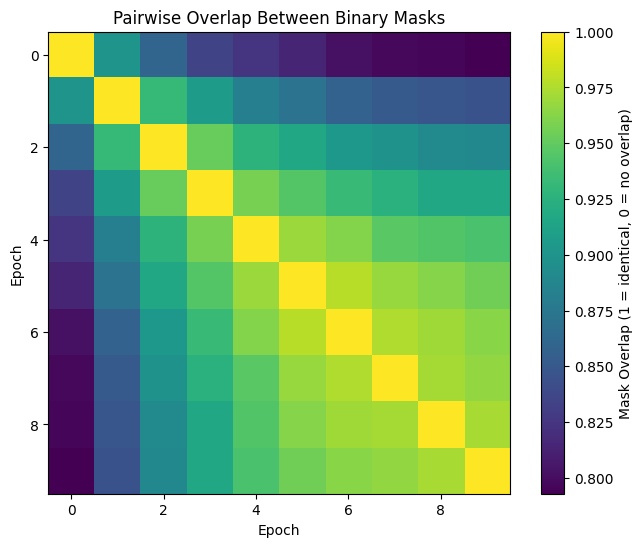

In [53]:
plot_mask_overlap_heatmap('./masks', output_path='overlap_heatmap.png')


If successful, you should see a plot like this:

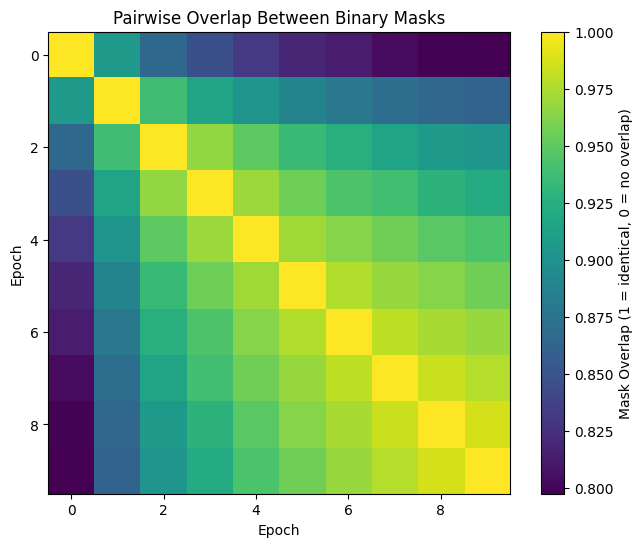

### Learning Rate Sensitivity: Mask Stability Across Training

Now, train five additional models using the following learning rates:

- `1e-2`
- `1e-3`
- `1e-4`
- `1e-5`

For each model:

1. Save the binary BatchNorm masks at the end of each epoch (as in Part 2).
2. Organize them in separate directories, such as:
   - `masks_lr_1e-2/`
   - `masks_lr_1e-3/`
   - `masks_lr_1e-4/`
   - `masks_lr_1e-5/`

3. Use the `plot_mask_overlap_heatmap()` function to:
   - Compute pairwise overlaps between masks across epochs.
   - Generate and save the corresponding heatmap.

> You are investigating how learning rate influences the **temporal stability** of channel importance as measured by binary masks. A more stable overlap across epochs may indicate that pruning decisions made early in training are reliable. Instability, on the other hand, may suggest that early pruning could disrupt learning or remove useful capacity.

Be sure to examine how each heatmap changes with learning rate, and compare their implications.


Learning Rate 0.01
Epoch [  1] | Train Loss: 1.7896 | LR: 0.010000
Epoch [  2] | Train Loss: 0.8240 | LR: 0.010000
Epoch [  3] | Train Loss: 0.5705 | LR: 0.010000
Epoch [  4] | Train Loss: 0.4435 | LR: 0.010000
Epoch [  5] | Train Loss: 0.3446 | LR: 0.010000
Epoch [  6] | Train Loss: 0.2701 | LR: 0.010000
Epoch [  7] | Train Loss: 0.2098 | LR: 0.010000
Epoch [  8] | Train Loss: 0.1687 | LR: 0.010000
Epoch [  9] | Train Loss: 0.1480 | LR: 0.010000
Epoch [ 10] | Train Loss: 0.1323 | LR: 0.010000
Saved overlap heatmap to: overlap_heatmap_0.01.png


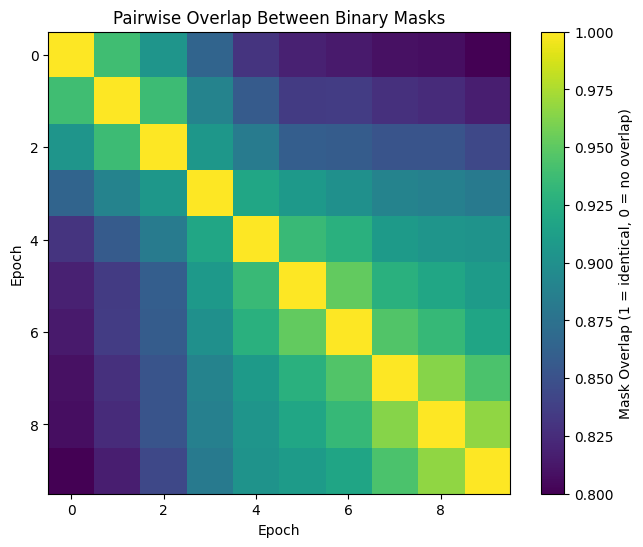

Learning Rate 0.001
Epoch [  1] | Train Loss: 1.0293 | LR: 0.001000
Epoch [  2] | Train Loss: 0.5878 | LR: 0.001000
Epoch [  3] | Train Loss: 0.4289 | LR: 0.001000
Epoch [  4] | Train Loss: 0.3059 | LR: 0.001000
Epoch [  5] | Train Loss: 0.2174 | LR: 0.001000
Epoch [  6] | Train Loss: 0.1434 | LR: 0.001000
Epoch [  7] | Train Loss: 0.0969 | LR: 0.001000
Epoch [  8] | Train Loss: 0.0734 | LR: 0.001000
Epoch [  9] | Train Loss: 0.0755 | LR: 0.001000
Epoch [ 10] | Train Loss: 0.0539 | LR: 0.001000
Saved overlap heatmap to: overlap_heatmap_0.001.png


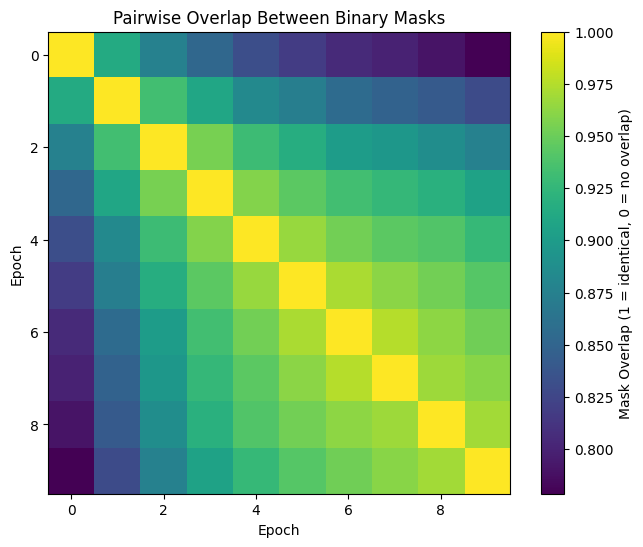

Learning Rate 0.0001
Epoch [  1] | Train Loss: 1.0907 | LR: 0.000100
Epoch [  2] | Train Loss: 0.6452 | LR: 0.000100
Epoch [  3] | Train Loss: 0.4320 | LR: 0.000100
Epoch [  4] | Train Loss: 0.2844 | LR: 0.000100
Epoch [  5] | Train Loss: 0.1654 | LR: 0.000100
Epoch [  6] | Train Loss: 0.0919 | LR: 0.000100
Epoch [  7] | Train Loss: 0.0603 | LR: 0.000100
Epoch [  8] | Train Loss: 0.0461 | LR: 0.000100
Epoch [  9] | Train Loss: 0.0488 | LR: 0.000100
Epoch [ 10] | Train Loss: 0.0327 | LR: 0.000100
Saved overlap heatmap to: overlap_heatmap_0.0001.png


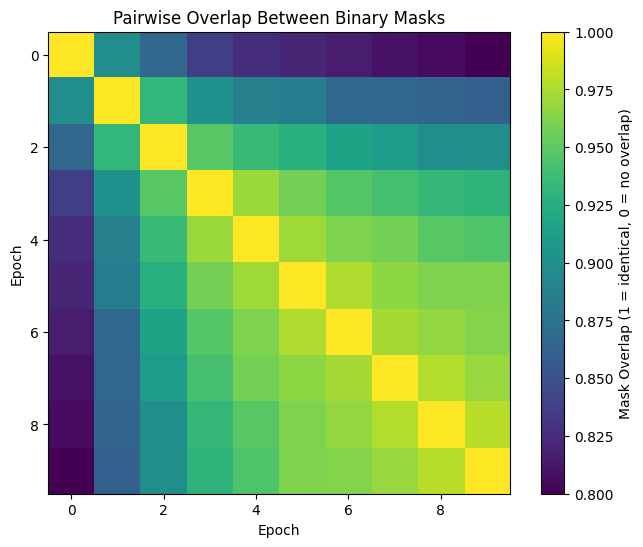

Learning Rate 1e-05
Epoch [  1] | Train Loss: 1.4431 | LR: 0.000010
Epoch [  2] | Train Loss: 1.0204 | LR: 0.000010
Epoch [  3] | Train Loss: 0.8227 | LR: 0.000010
Epoch [  4] | Train Loss: 0.6765 | LR: 0.000010
Epoch [  5] | Train Loss: 0.5606 | LR: 0.000010
Epoch [  6] | Train Loss: 0.4625 | LR: 0.000010
Epoch [  7] | Train Loss: 0.3797 | LR: 0.000010
Epoch [  8] | Train Loss: 0.3089 | LR: 0.000010
Epoch [  9] | Train Loss: 0.2495 | LR: 0.000010
Epoch [ 10] | Train Loss: 0.1964 | LR: 0.000010
Saved overlap heatmap to: overlap_heatmap_1e-05.png


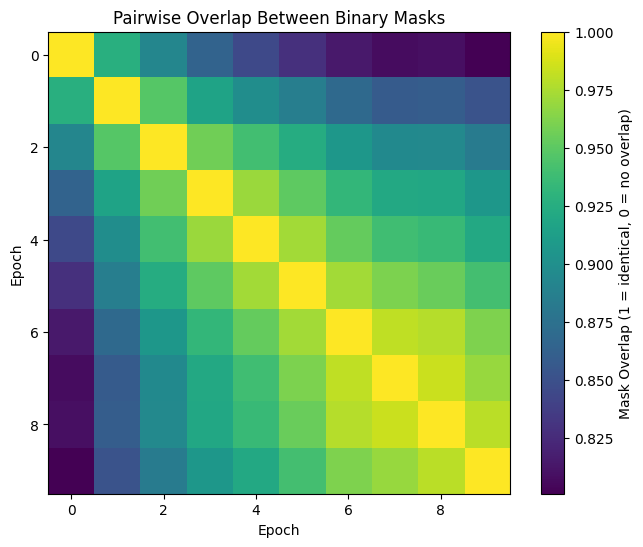

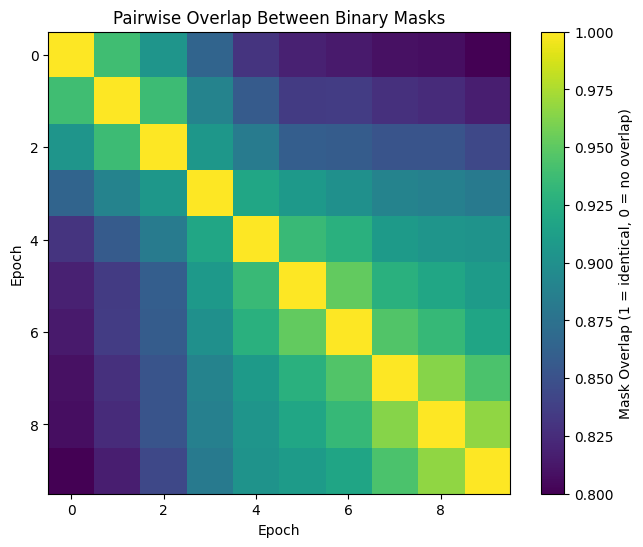

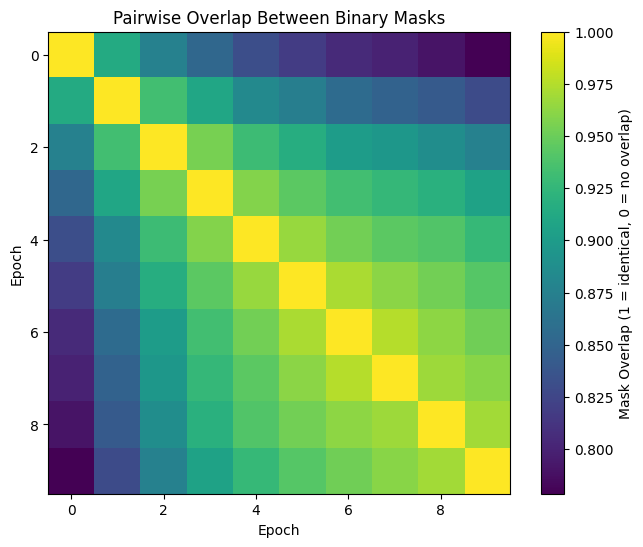

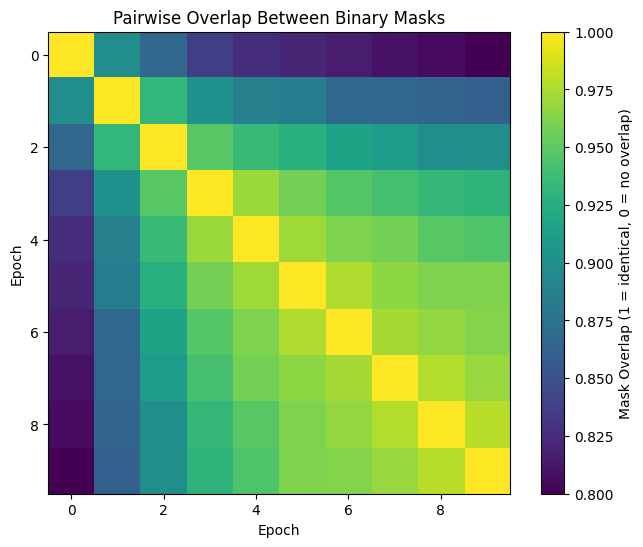

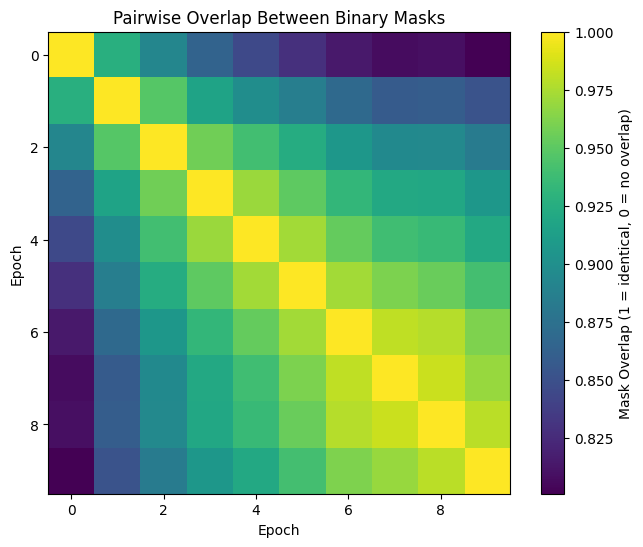

In [59]:
for lr in [1e-2, 1e-3, 1e-4, 1e-5]:
    print("=====================")
    print(f"Learning Rate {lr}")
    print("=====================")
    mask_dir = f"./masks_lr_{lr}"
    output_path = f"overlap_heatmap_{lr}.png"
    model_lr = ResNet9(CIFAR10_CHANNELS, CIFAR10_CLASSES)
    train(model_lr, train_loader, mask_dir, num_epochs=10, lr=lr)
    plot_mask_overlap_heatmap(mask_dir, output_path=output_path)
    display(Image(filename=output_path))

### Stability Analysis

The training performance demonstrates clear convergence patterns across learning rates. With a learning rate of 0.01 (1e-2), the model converges the fastest, dropping loss from 1.79 to 0.13, though this speed introduces volatility. At 0.001 (1e-3), convergence is balanced and efficient, with loss decreasing from 1.03 to 0.05. A rate of 0.0001 (1e-4) provides steady, gradual updates and achieves the lowest final loss of 0.03, while 1e-5 yields the slowest convergence, reducing loss only from 1.44 to 0.20 and reflecting minimal weight changes.

### Heatmap Analysis

#### 1. Which learning rate produced the most stable masks across epochs?

The heatmaps highlight that a learning rate of 1e-4 produces the most stable masks across epochs. Consistently bright, yellow regions indicate high overlap (greater than 0.9) between epoch pairs, showing excellent stability while still supporting meaningful learning. This makes 1e-4 the optimal choice for pruning applications, offering the best combination of mask consistency and learning effectiveness.

#### 2. How does mask stability relate to training dynamics?

The heatmaps reveals a concave relationship between mask stability and training dynamics. At a learning rate of 0.01, darker regions show frequent changes in channel importance due to aggressive weight updates. A rate of 0.001 stabilizes after early fluctuations, 0.0001 is the most stable in terms of the heatmap throughout training. Interestingly, 0.00001 shows a degredation in the stability of the heatmap.

#### 3. Do lower learning rates always lead to higher stability?

Lower learning rates generally lead to higher stability, but with notable trade-offs. Specifically 1e-5 shows a degredation in stability of the mask compared to 1e-4 and also notably has a higher loss than 1e-4 implying it hasn't fully converged or converged upon a local minima.

#### 4. Reliability of early importance scores?

The reliability of early importance scores depends on learning rate. High rates such as 1e-2 produce volatile, unreliable early scores, while moderate rates like 1e-4 and 1e-3 stabilize within two to three epochs, making early pruning feasible. Although 1e-5 appears stable from the start, the fact that it has a greater instability than 1e-5 means that this is more reliable than 1e-2 but not as reliable as 1e-4. Given this, you should allow two to three epochs for stabilization before pruning.